In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sep
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.io
from astropy.io import fits

rcParams['figure.figsize'] = [10.,8.]

In [2]:
#read image into standard 2-d numpy array with 2nd image
data = fits.getdata(r"S:\Users\John\Downloads\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

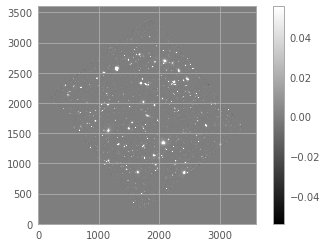

In [3]:
m , s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.imsave('image.png', data, cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

#### Repeat background subtraction from part 1

In [4]:
#measure a spatially varying background on the image
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

In [5]:
# get a "global" mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [6]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

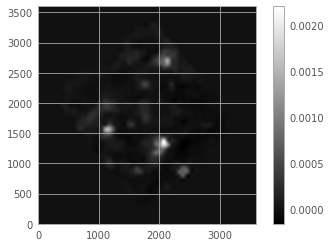

In [7]:
#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.imsave('Background.png',bkg_image, cmap='gray', origin='lower')
plt.colorbar();

In [8]:
#evaluate the background noise as 2-d array
bkg_rms = bkg.rms()

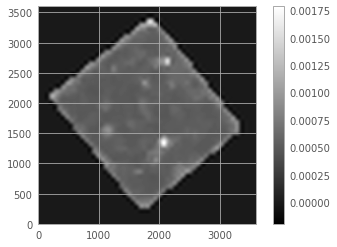

In [9]:
#show background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.imsave('BackgroundNoise.png', bkg_rms, cmap='gray', origin='lower')
plt.colorbar();

In [10]:
#subtract the background
data_sub=data-bkg.back()

Repeat object detection

In [11]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [12]:
#how many objects were detected?
len(objects)

8645

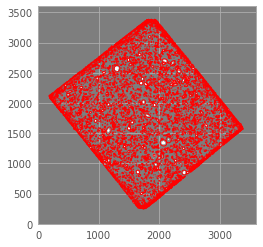

In [13]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
fig.savefig('DetectedObjects.png')

In [14]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [15]:
#Perform circular aperture photometry with a 3 pixel radius at the locations of the objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [16]:
#Show the first 10 objects results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


TypeError: cannot perform reduce with flexible type

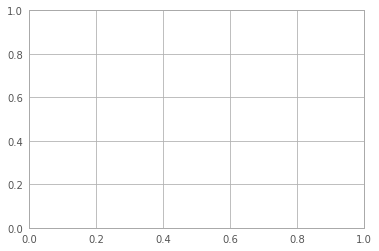

In [38]:
plt.hist(objects.flatten(), bins=30)

### Convert to AB magnitude (prodedure found online)

In [36]:
import astropy.units as u
import astropy.constants as c
ABobjects = objects[:]
tint = 1000.*u.s
cr_b = ([3000., 100., 15.] * u.ct) / tint
cr_v = ([4000., 90., 25.] * u.ct) / tint
b_i, v_i = u.Magnitude(cr_b), u.Magnitude(cr_v)
b_i, v_i

(<Magnitude [-1.19280314,  2.5       ,  4.55977185] mag(ct / s)>,
 <Magnitude [-1.50514998,  2.61439373,  4.00514998] mag(ct / s)>)

In [18]:
b_i - v_i

<Magnitude [ 0.31234684, -0.11439373,  0.55462187] mag>

In [22]:
b_ref, v_ref = 17.2 * u.STmag, 17.0 * u.STmag
b_ref, v_ref

(<Magnitude 17.2 mag(ST)>, <Magnitude 17. mag(ST)>)

In [23]:
zp_b, zp_v = b_ref - b_i0[0], v_ref - v_i0[0]
zp_b, zp_v

(<Magnitude 18.56250876 mag(s ST / ct)>,
 <Magnitude 18.67485561 mag(s ST / ct)>)

In [26]:
(0. * u.STmag).to(u.erg/u.s/u.cm**2/u.AA)  
#<Quantity 3.63078055e-09 erg / (Angstrom cm2 s)>

<Quantity 3.63078055e-09 erg / (Angstrom cm2 s)>

In [25]:
(-21.1 * u.STmag).to(u.erg/u.s/u.cm**2/u.AA)

<Quantity 1. erg / (Angstrom cm2 s)>

In [27]:
B, V = b_i0 + zp_b, v_i0 + zp_v
B, V

(<Magnitude [17.2       , 20.89280314, 22.95257499] mag(ST)>,
 <Magnitude [17.        , 21.1195437 , 22.51029996] mag(ST)>)

In [29]:
V.to(u.ABmag, u.spectral_density(5500.*u.AA))  
#<Magnitude [16.99023831, 21.10978201, 22.50053827] mag(AB)>

<Magnitude [16.99023831, 21.10978201, 22.50053827] mag(AB)>

Make histogram

TypeError: cannot perform reduce with flexible type

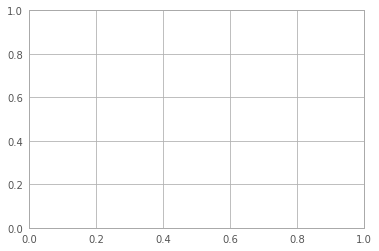

In [32]:
histogram = plt.hist(objects.flatten(), bins='auto')


#flux = np.arange(1,10**19,10**17)
#n = np.arange(0,100,1)
#flux_norm= (np.multiply(n,flux))
#plt.hist(flux_norm, bins = 30)
##plt.xlim(0,10)
##plt.ylim(0,10**19)
#plt.title("Histogram of Normalized Flux")
#plt.xlabel("Energy (MeV)")
#plt.ylabel("Normalized flux")

#plt.show()